In [1]:
# pip install yfinance

In [2]:
# Load Packages
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime, timedelta

# Section 1: Define Tickers and Time Range

In [3]:
tickers = ['SPY','BND','GLD','QQQ','VTI']
end_date = datetime.today()
start_date = end_date - timedelta(days = 5*365)

# Section 2: Download Adjusted Close Prices

In [4]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']
adj_close_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


SPY        BND         GLD         QQQ         VTI
Date                                                                 
2018-10-05  264.774445  68.454674  113.800003  174.257797  135.826782
2018-10-08  264.774445  68.428299  112.540001  173.193802  135.725571
2018-10-09  264.388123  68.560349  112.599998  173.754791  135.486359
2018-10-10  256.016754  68.507538  112.879997  166.113190  131.171326
2018-10-11  250.377533  68.701202  115.779999  164.052856  128.374390
...                ...        ...         ...         ...         ...
2023-09-27  426.049988  69.438408  174.100006  355.040009  211.630005
2023-09-28  428.519989  69.617912  173.229996  358.010010  213.029999
2023-09-29  427.480011  69.587997  171.449997  358.269989  212.410004
2023-10-02  427.309998  69.110001  169.649994  361.260010  212.130005
2023-10-03  421.589996  68.550003  169.160004  354.920013  209.050003

[1256 rows x 5 columns]

In [5]:
adj_close_df[["SPY", "BND", "GLD"]].to_csv('out.csv')

# Section 3: Calculate Lognormal Returns

In [6]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns.head()

SPY       BND       GLD       QQQ       VTI
Date                                                        
2018-10-05       NaN       NaN       NaN       NaN       NaN
2018-10-08  0.000000 -0.000385 -0.011134 -0.006125 -0.000745
2018-10-09 -0.001460  0.001928  0.000533  0.003234 -0.001764
2018-10-10 -0.032175 -0.000771  0.002484 -0.044976 -0.032367
2018-10-11 -0.022273  0.002823  0.025367 -0.012481 -0.021553

In [7]:
log_returns = log_returns.dropna()
log_returns.head()

SPY       BND       GLD       QQQ       VTI
Date                                                        
2018-10-08  0.000000 -0.000385 -0.011134 -0.006125 -0.000745
2018-10-09 -0.001460  0.001928  0.000533  0.003234 -0.001764
2018-10-10 -0.032175 -0.000771  0.002484 -0.044976 -0.032367
2018-10-11 -0.022273  0.002823  0.025367 -0.012481 -0.021553
2018-10-12  0.013793 -0.000257 -0.004762  0.027450  0.013101

# Section 4: Calculate Covariance Matrix

In [8]:
cov_matrix = log_returns.cov() * 252
cov_matrix

SPY       BND       GLD       QQQ       VTI
SPY  0.046663  0.002396  0.003097  0.053097  0.047655
BND  0.002396  0.004296  0.003659  0.002974  0.002536
GLD  0.003097  0.003659  0.021838  0.004499  0.003261
QQQ  0.053097  0.002974  0.004499  0.069357  0.054187
VTI  0.047655  0.002536  0.003261  0.054187  0.049041

# Section 5: Define Portfolio Performance Metrics

In [34]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(((np.exp(log_returns.mean()*252)-1))*weights)

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

# Section 6: Portfolio Optimization

In [35]:
risk_free_rate = .02

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

optimized_results = minimize(neg_sharpe_ratio, 
                             initial_weights, 
                             args=(log_returns, cov_matrix, risk_free_rate), 
                             method='SLSQP', 
                             constraints=constraints, 
                             bounds=bounds)

# Section 7: Analyze the Optimal Portfolio

In [36]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.1543
BND: 0.0457
GLD: 0.4000
QQQ: 0.4000
VTI: 0.0000
Expected Annual Return: 0.1097
Expected Volatility: 0.1561
Sharpe Ratio: 0.5745


# Section 8: Display the Final Portfolio in a Plot

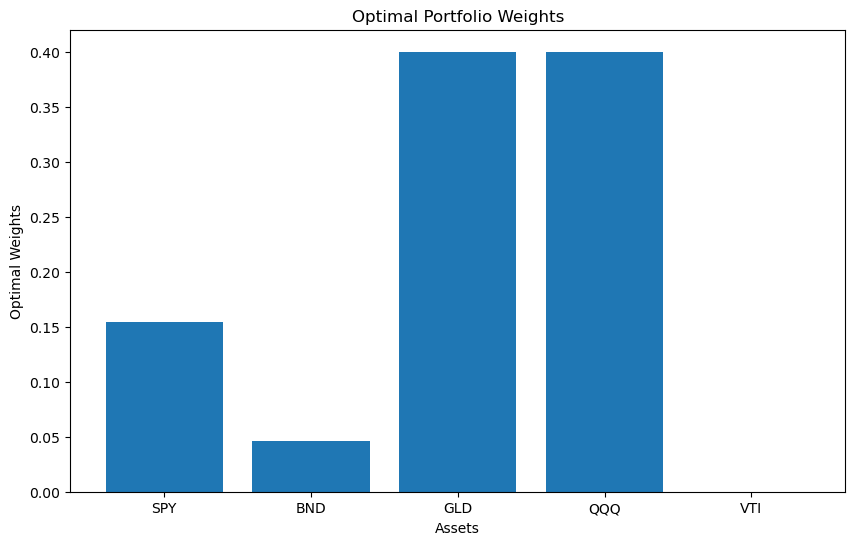

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()